# Vision-based Evals in JavaScript

LangSmith's support for custom evaluators grants you great flexibility with checking your chains against datasets. One exciting possibility for certain visual generative use cases is prompting vision models to determine success.

This notebook will walk through an example of refining a chain that generates HTML pages. We'll create a custom evaluator that first renders the outputs using a headless browser called [Puppeteer](https://pptr.dev/), passes the screenshots to OpenAI's GPT-4V, and returns a score. Let's dive in!

## Prerequisites

This tutorial uses OpenAI models and LangChain to compose the chain. To make sure the tracing and evals are set up for [LangSmith](https://smith.langchain.com), please configure your API keys appropriately.

This notebook will use the [Deno](https://deno.com/), so you'll need to [download and set it up](https://docs.deno.com/runtime/manual) in order to follow along. However, the principles and general steps of the guide apply to other JavaScript runtimes as well.

## Setup

To begin, let's set up our Chrome Puppeteer binary. This is what we'll use to render HTML and take screenshots of our chain's generations. Run the following command in your terminal from this path:

Next, make sure you've set up a `.env` file with your OpenAI key set as `OPENAI_API_KEY` and your LangSmith API key set as `LANGCHAIN_API_KEY`. Additionally, you should set `LANGCHAIN_TRACING_V2=true` to enable tracing.

In [1]:
import "dotenv/config";

[Module: null prototype] { default: {} }

Next, let's set up a simple, naive chain that will generate HTML given some input:

In [2]:
import { ChatPromptTemplate } from "@langchain/core/prompts";
import { ChatOpenAI } from "@langchain/openai";
import { StringOutputParser } from "@langchain/core/output_parsers";

const prompt = ChatPromptTemplate.fromTemplate(`Generate an HTML for a webpage implementing the following. Do not return anything other than valid HTML.\n\n{input}`);
const model = new ChatOpenAI({ temperature: 0 });

const chain = prompt.pipe(model).pipe(new StringOutputParser());

In [3]:
const html = await chain.invoke({
  input: "a tax calculator",
});

html

"<!DOCTYPE html>\n" +
  "<html>\n" +
  "<head>\n" +
  "  <title>Tax Calculator</title>\n" +
  "</head>\n" +
  "<body>\n" +
  "  <h1>Tax Calculator</h"... 762 more characters

Now let's define a function that uses Puppeteer to render that HTML output as an image:

In [4]:
import puppeteer from "puppeteer";

async function renderHtml(html) {
  const browser = await puppeteer.launch();
  const page = await browser.newPage();
  // Set the page content to our HTML.
  // Puppeteer can also navigate to websites - for more options see https://pptr.dev
  await page.setContent(html);
  const screenshot = await page.screenshot({ encoding: "base64" });

  await browser.close();
  return screenshot;
}

In [5]:
const image = await renderHtml(html);

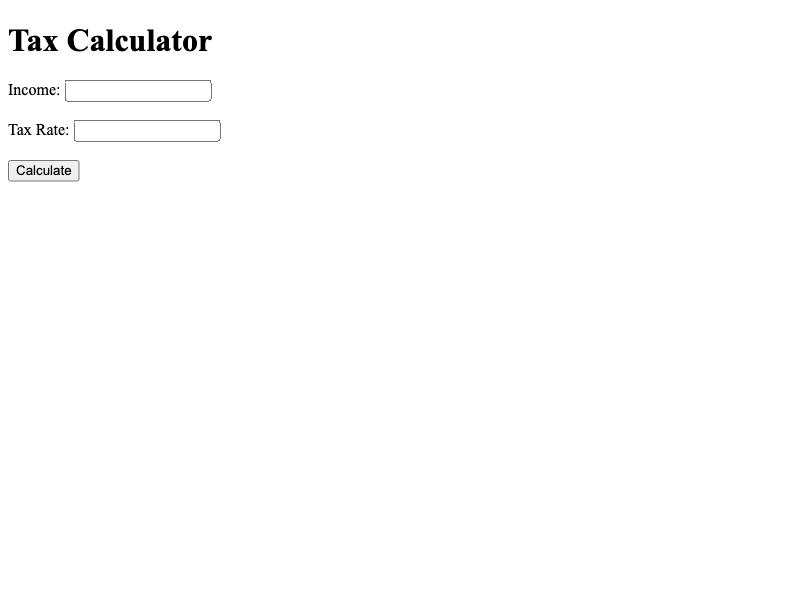

In [6]:
import { display } from "https://deno.land/x/display/mod.ts";

await display({ 
  "image/jpeg": image,
}, { raw: true });

Sweet! Now, let's create a LangSmith dataset. These are input/output pairs where the input is an example input to our chain, and the output is an ideal generation your chain to create in response to that input.

For this demo notebook, we'll quickly generate reference examples using the direct output of the chain we're evaluating. In a real-world situation, you would want to use the best quality examples you can for your reference outputs, either curated by hand or using the best model possible.

In [7]:
const inputs = [
  { input: "a tax calculator" },
  { input: "a social media website for sharing photos" },
  { input: "an e-commerce startup landing page" },
];

const results = await chain.batch(inputs);

const referenceOutputs = results.map((result) => {
  return { output: result };
});

In [8]:
import { Client } from "langsmith";

const client = new Client();

const datasetName = `lcjs-vision-eval-demo-${new Date().toISOString()}`;
const dataset = await client.createDataset(datasetName);

await Promise.all(
  inputs.map(async (input, i) => {
    await client.createExample(input, referenceOutputs[i], {
      datasetId: dataset.id,
    });
  })
);

[ undefined, undefined, undefined ]

You can log into https://smith.langchain.com/datasets to see the newly created dataset.

Now, let's combine this with a vision model in a custom evaluator function. Custom evaluators take a few parameters, defined in the type `DynamicRunEvaluatorParams`. These include:

- `input`: The raw input from the dataset used to call the chain.
- `prediction`: The raw output from the chain.
- `reference`: The raw reference output from our compiled dataset.
- `run`: Raw metadata from the chain run that the evaluator is acting on.
- `example`: The full raw example from the dataset.

`input`, `prediction`, and `reference` are all present on the raw `run` and `example` objects. They are parsed out for your convenience.

Here's what this might look like:

In [9]:
import type { DynamicRunEvaluatorParams } from "langchain/smith";
import type { RunnableConfig } from "@langchain/core/runnables";
import { HumanMessage } from "@langchain/core/messages";

const visionBasedEvaluator = async (
  {
    run,
    example,
    input,
    prediction,
    reference,
  }: DynamicRunEvaluatorParams, 
  options: { config: RunnableConfig }
) => {
  if (typeof prediction?.output !== "string") {
    throw new Error(
      "Invalid prediction format for this evaluator. Please check your chain's outputs and try again."
    );
  }
  const imageBase64 = await renderHtml(prediction.output);
  const visionModel = new ChatOpenAI({
    modelName: "gpt-4-vision-preview",
    temperature: 0,
    maxTokens: 2000,
  });
  const visionEvaluatorChain = visionModel.pipe(new StringOutputParser());
  // Simple evaluation prompt, tweak for your use case.
  const chainInputMessage = new HumanMessage({
    content: [
      {
        type: "text",
        text: `An AI model was asked to generate "${input.input}", and responded with the following image.
        Please assign the image a score between 0 and 10 based on quality and faithfulness to "${input.input}" where 0 is completely off target
        and 10 is an exact representation of what was desired.

        Do not return anything other than a number`,
      },
      {
        type: "image_url",
        image_url: {
          url: `data:image/jpeg;base64,${imageBase64}`,
        },
      },
    ]
  });

  const response = await visionEvaluatorChain.invoke([
    chainInputMessage
  ], options.config);

  const score = parseInt(response, 10);

  return {
    key: "visual_generation_quality",
    score: score / 10,
    comment: response,
  };
};

For the demo, we aren't using the reference outputs since they are just previous runs of the same chain. In a real-world situation, you might want to have the evaluator take the reference output into account when generating a score.

And now, the final step is to run our chain on our dataset and evaluate it with our new custom evaluator. Here's how that looks:

In [10]:
import { runOnDataset } from "langchain/smith";

const finalResults = await runOnDataset(chain, datasetName, {
  evaluationConfig: {
    customEvaluators: [visionBasedEvaluator]
  },
});

Predicting: ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ 100.00% | 3/3

Completed
Running Evaluators: ▓▓▓▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░ 33.33% | 1/3

Running Evaluators: ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░░░░ 66.67% | 2/3

Running Evaluators: ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ 100.00% | 3/3



And now if you go back to https://smith.langchain.com/datasets and look at your dataset, you should see a populated test run!

Clicking into the test run, you'll see the chain input, the chain output, and the reference output. You'll also see the score the `visionBasedEvaluator` returned above:

![](./img/test_run.png)

## Conclusion

And that's it! You've set up a vision evaluator based powered by GPT-4V and Puppeteer.

For further reading, check out the following guides:

- [JS LangSmith walkthrough](https://js.langchain.com/docs/guides/langsmith_evaluation)
- [Evaluation quickstart](https://docs.smith.langchain.com/evaluation/quickstart)